The decision for converting a predicted probability or scoring into a class label is governed by 
a parameter referred to as the “decision threshold,” “discrimination threshold,” or simply the “threshold.” 
The default value for the threshold is 0.5 for normalized predicted probabilities or scores in the range 
between 0 or 1.

For example, on a binary classification problem with class labels 0 and 1, normalized predicted 
probabilities and a threshold of 0.5, then values less than the threshold of 0.5 are assigned to 
class 0 and values greater than or equal to 0.5 are assigned to class 1.

Prediction < 0.5 = Class 0
Prediction >= 0.5 = Class 1


NOTE: The problem is that the default threshold may not represent an optimal interpretation 
      of the predicted probabilities.
        
there is often the need to change the default decision threshold when interpreting the predictions of a model

For example, you may use ROC curves to analyze the predicted probabilities of a model and ROC AUC scores 
to compare and select a model, although you require crisp class labels from your model.

# Optimal Threshold For ROC Curve

A ROC curve is a diagnostic plot that evaluates a set of probability predictions made by a model on 
a test dataset.

A set of different thresholds are used to interpret the true positive rate and the false positive rate 
of the predictions on the positive (minority) class, and the scores are plotted in a line of increasing 
thresholds to create a curve.

The false-positive rate is plotted on the x-axis and the true positive rate is plotted on the y-axis and 
the plot is referred to as the Receiver Operating Characteristic curve, or ROC curve. A diagonal line on 
the plot from the bottom-left to top-right indicates the “curve” for a no-skill classifier (predicts the 
majority class in all cases), and a point in the top left of the plot indicates a model with perfect skill.

The ROC Curve is a useful diagnostic tool for understanding the trade-off for different thresholds and 
the ROC AUC provides a useful number for comparing models based on their general capabilities.

In [80]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#from matplotlib import pyplot

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

from sklearn.linear_model import LogisticRegression

In [81]:
#10000 rows and 2 columns.  99 percent of which belong to the majority class and 1 percent belong to the 
#minority class. 
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

In [82]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

In [83]:
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
lr_probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

In [84]:
#fpr = meaning is 'false positive rate'
#tpr = meaning is 'true positive rate'
fpr, tpr, thresholds = roc_curve(testy, lr_probs)

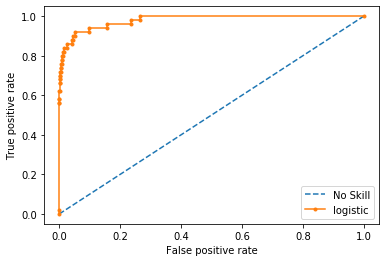

In [85]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='logistic')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

We can see that there are a number of points or thresholds close to the top-left of the plot.
But Which is the threshold that is optimal?

Firstly, the true positive rate is called the Sensitivity. The inverse of the false-positive rate is called 
the Specificity.


    Sensitivity = TruePositive / (TruePositive + FalseNegative)
    Specificity = TrueNegative / (FalsePositive + TrueNegative)

Where:

    Sensitivity = True Positive Rate
    Specificity = 1 – False Positive Rate

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a 
balance between the sensitivity and the specificity.

    G-Mean = sqrt(Sensitivity * Specificity)

One approach would be to test the model with each threshold returned from the call roc_auc_score() and 
select the threshold with the largest G-Mean value.

Given that we have already calculated the Sensitivity (TPR) and the complement to the Specificity when we 
calculated the ROC Curve, we can calculate the G-Mean for each threshold directly.

In [86]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

In [87]:
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.016153, G-Mean=0.933


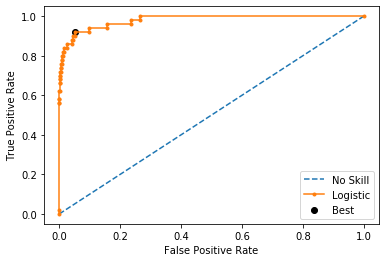

In [88]:
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
pyplot.show()

Now we found the optimal threshold

# Optimal Threshold for Precision-Recall Curve

In [89]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, lr_probs)

Text(0.5, 1.0, 'Precision_Recall Curve for LogisticRegression')

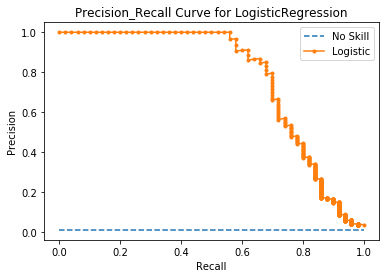

In [90]:
# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.title('Precision_Recall Curve for LogisticRegression')

But where is the best threshold?

In [91]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.256036, F-Score=0.756


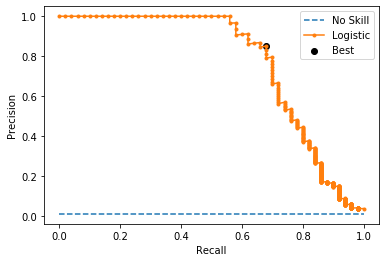

In [92]:
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

# Optimal Threshold Tuning

In [93]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
 
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)

# predict probabilities
yhat = model.predict_proba(testX)

# keep probabilities for the positive outcome only
probs = yhat[:, 1]

# define thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold
scores = [f1_score(testy, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.251, F-Score=0.75556


Running the example reports the optimal threshold as 0.251 (compared to the default of 0.5) that 
achieves an F-Measure of about 0.75 (compared to 0.70).